# Linear/Logistic Regression as A Single-layer Fully Connected Neural Network  

# ![title](img/1.png)

We can think of linear/logistic regression as a single-layer fully connected neural network with different prediction head (SoftMax for logistic regression), as the input is $x_1$, $x_2$ to $x_d$ where $d$ is the input dimension, and a single computed neuron outputs a single numerical value $o_1$. We will first focus on the single-layer fully connected neural network for regression on the synthetic data in $1.1$ and for classification on MNIST dataset in $1.2$. In $1.3$, we will implement Multilayer Perceptrons (MLP) for classification on MNIST dataset.

## Linear Neural Networks for regression


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Synthetic Data

We aim to synthesize data from the following linear model:

$\mathbf{y}=\mathbf{X} \mathbf{w}+b+\boldsymbol{\epsilon},$

where $\mathbf{X} \in \mathbb{R}^{n \times d}$, $\boldsymbol{\epsilon}\in\mathbb{R}^{n \times 1}$, $\mathbf{w}\in\mathbb{R}^{d \times 1}$ and $\mathbf{y}\in\mathbb{R}^{n \times 1}$. Sample $\mathbf{X}$ and $\boldsymbol{\epsilon}$ from normal distribution ( ${\mu=0,\sigma=1}$ for $\mathbf{X}$, ${\mu=0,\sigma=0.01}$ for $\boldsymbol{\epsilon}$ ). With your setted $\mathbf{w}$ and $b$, synthetic $y$ is also formed.

In [2]:

class SyntheticRegressionData(Dataset):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000):
        super(SyntheticRegressionData, self).__init__()
        self.w = w
        self.b = b
        self.noise = noise
        self.num_train = num_train
        self.num_val = num_val
        self.total_samples = num_train + num_val
        self.prepare_data()

    def prepare_data(self):
        # sample X, noise using torch.randn
        self.X = torch.randn(self.total_samples, len(self.w))
        noise = torch.randn(self.total_samples, 1) * self.noise

        # generate y using torch.randn torch.matmul
        #\mathbf{y}=\mathbf{X} \mathbf{w}+b+\boldsymbol{\epsilon}
        self.y = torch.matmul(self.X, self.w.view(-1, 1)) + self.b + noise

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Formulate Linear Neural Networks Model

In [3]:
class LinearRegression(nn.Module):
    # define the learning rate, single-layer Linear Neural Networks `net` using linear layer in torch.nn. Default dimension: d=2
    def __init__(self, lr):
        super(LinearRegression, self).__init__()
        self.lr = lr
        self.net = nn.Linear(2, 1)
        self.init_weights()

    # using nn.init to initialize net.weight (normal_, mean=0, std=0.01) and net.bias (constant_, mean=0).
    def init_weights(self):
        nn.init.normal_(self.net.weight, mean=0, std=0.01)
        nn.init.constant_(self.net.bias, 0)

    # define the forward funtion for forward propagation of `net`
    def forward(self, x):
        return self.net(x)

    # define the MSE loss funtion for the regression task.
    def loss(self, y_hat, y):
        return nn.functional.mse_loss(y_hat, y)

    # define the SGD optimizer from torch for back propagation
    def optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

### Define the Trainer for Regression

Implementing `__init__` to split the data and initialize the training setting, the training function `fit` for model training and `plot_losses` to plot `train_loss` and `val_loss` of each epoch.

In [4]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split

class Trainer_reg:
    def __init__(self, model, data, max_epochs=3, batch_size=32, val_ratio=0.2,device='cpu'):
        # Initialize the model and training setting
        self.model = model.to(device)
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.optimizer = model.optimizers()
        self.device = device

        # Split data into training and validation sets with the `val_ratio` and define the train_loader and val_loader using `DataLoader` with the `batch_size`
        train_size = int((1 - val_ratio) * len(data))
        val_size = len(data) - train_size
        self.train_data, self.val_data = random_split(data, [train_size, val_size])
        self.train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False)

        # To store the losses for plotting
        self.train_losses = []
        self.val_losses = []

    def fit(self):
        #define each training epoch
        for epoch in range(self.max_epochs):
            # set training mode
            self.model.train()

            train_loss = 0
            # forward then back propagation for each batch
            for X, y in self.train_loader:
                if self.device == 'cuda':
                    X, y = X.to('cuda'), y.to('cuda')
                else:
                    X, y = X.float(), y.float()
                # forward propagation for prediction
                y_hat = self.model(X)
                # loss computation
                loss = self.model.loss(y_hat, y)

                # 3 steps for back propagation: (1) clear the gradient in the optimizer; (2) backward the loss to get the gradient of each parameter; (3) update the parameters using optimizer.
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * X.size(0)
            avg_train_loss = train_loss / len(self.train_data)

            # Validation phase
            # set evaluation model for model
            self.model.eval()

            val_loss = 0
            # set torch with forwarding without gradient awareness
            with torch.no_grad():
                for X, y in self.val_loader:

                    if self.device == 'cuda':
                        X, y = X.to('cuda'), y.to('cuda')
                    else:
                        X, y = X.float(), y.float()
                # forward propagation and compute loss for each batch
                for X, y in self.val_loader:
                    y_hat = self.model(X)
                    loss = self.model.loss(y_hat, y)
                    val_loss += loss.item() * X.size(0)
            avg_val_loss = val_loss / len(self.val_data)

            # Logging the losses
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)

            print(f'Epoch [{epoch + 1}/{self.max_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    def plot_losses(self):
        # plot `self.train_losses` and `self.val_losses` for all epochs
        plt.plot(range(1, self.max_epochs + 1), self.train_losses, label='Train Loss')
        plt.plot(range(1, self.max_epochs + 1), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Losses')
        plt.show()


### Trainning the Model

Epoch [1/10], Train Loss: 14.7014, Val Loss: 4.3240
Epoch [2/10], Train Loss: 1.8252, Val Loss: 0.5384
Epoch [3/10], Train Loss: 0.2270, Val Loss: 0.0674
Epoch [4/10], Train Loss: 0.0284, Val Loss: 0.0086
Epoch [5/10], Train Loss: 0.0036, Val Loss: 0.0012
Epoch [6/10], Train Loss: 0.0005, Val Loss: 0.0002
Epoch [7/10], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [9/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [10/10], Train Loss: 0.0001, Val Loss: 0.0001


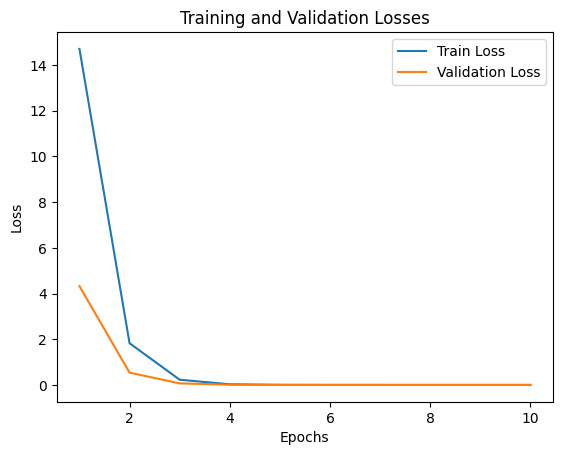

In [5]:
# (1) Instantiate your model with your defined 'LinearRegression'
model = LinearRegression(lr=0.01)
# (2) generate the synthetic data with your defined w and b
w = torch.tensor([2.0, -3.4])
b = 4.2
data = SyntheticRegressionData(w=w, b=b, noise=0.01)
# (3) Instantiate the trainer and fit your model
trainer = Trainer_reg(model=model, data=data, max_epochs=10, batch_size=32, val_ratio=0.2, device='cpu')
# (4) Start training
trainer.fit()
# plot the loss
trainer.plot_losses()

## Single-layer Neural Networks for classification

In this part, we will build a single-layer Neural Network for classification on MNIST dataset. THe differences are (1)additional SoftMax function is applied on the outputs, (2) Cross Entropy loss instead of MSE.


### Formulate the Single-layer Neural Networks Model for Classification

In [6]:
import torch.nn.functional as F

class SoftmaxRegression(nn.Module):
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super(SoftmaxRegression, self).__init__()
        self.lr = lr
        self.net = nn.Sequential(
            nn.Flatten(),  # Flatten the input tensor
            nn.Linear(28 * 28, num_outputs)  # Linear layer to output logits
        )

    def forward(self, X):
        #forward propagation with softmax
        logits = self.net(X)
        return F.softmax(logits, dim=1)

    # define the cross entropy loss funtion for the classification task.
    def loss(self, Y_hat, Y, averaged=True):
        return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'sum')

    # define the SGD optimizer from torch for back propagation
    def optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

### Define the Trainer for Classification

Most of `Trainer_cls` is similar with the `Trainer_reg`. 

We additionally compute the validation accuracy,  plot all epoches' `val_acc` with `train_loss` and `val_loss` in `plot_losses`.

In [7]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

class Trainer_cls:
    def __init__(self, model, data, max_epochs=3, batch_size=32, val_ratio=0.2,device='cpu'):
        self.model = model.to(device)
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.optimizer = model.optimizers()
        self.device = device

        train_size = int((1 - val_ratio) * len(data))
        val_size = len(data) - train_size
        self.train_data, self.val_data = random_split(data, [train_size, val_size])
        self.train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False)





        # To store the metrics for plotting
        self.train_losses = []
        self.val_losses = []
        self.val_acc = []  # To store validation accuracy

    def fit(self):
        for epoch in range(self.max_epochs):
            # Validation phase should include validation accuracy
            self.model.train()
            train_loss = 0

            for X, y in self.train_loader:
                if self.device == 'cuda':
                    X, y = X.to('cuda'), y.to('cuda')
                else:
                    X, y = X.float(), y.long()

                # Forward propagation for prediction
                y_hat = self.model(X)

                # Loss computation
                loss = self.model.loss(y_hat, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * X.size(0)
            avg_train_loss = train_loss / len(self.train_data)

            # Validation phase
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for X, y in self.val_loader:
                    if self.device == 'cuda':
                        X, y = X.to('cuda'), y.to('cuda')
                    else:
                        X, y = X.float(), y.long()

                    # Forward propagation for prediction
                    y_hat = self.model(X)

                    # Loss computation
                    loss = self.model.loss(y_hat, y)
                    val_loss += loss.item() * X.size(0)

                    # Accuracy computation
                    _, predicted = torch.max(y_hat, 1)
                    correct += (predicted == y).sum().item()
                    total += y.size(0)

            avg_val_loss = val_loss / len(self.val_data)

            val_accuracy = 100 * correct / total

            # Logging the metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.val_acc.append(val_accuracy)

            print(f'Epoch [{epoch + 1}/{self.max_epochs}]: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    def plot_losses(self):
        # plot `self.train_losses`, `self.val_losses` and `self.val_acc` for all epochs
        epochs = range(1, self.max_epochs + 1)
        plt.figure(figsize=(12, 6))

        # Plot training and validation loss
        plt.plot(epochs, self.train_losses, label='Train Loss', color='blue')
        plt.plot(epochs, self.val_losses, label='Validation Loss', color='orange')

        # Plot validation accuracy with a second y-axis
        ax = plt.gca()  # Get current axis
        ax2 = ax.twinx()  # Create a second y-axis
        ax2.plot(epochs, self.val_acc, label='Validation Accuracy', color='green')

        # Set labels for both y-axes
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy')

        # Set title and legend
        plt.title('Training Loss, Validation Loss, and Validation Accuracy')
        fig = plt.gcf()  # Get the current figure
        fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

        # Show grid and plot
        plt.grid(True)
        plt.show()

### Trainning the Model

Useing `SoftmaxRegression`, `Trainer_cls`.


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.68MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.62MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/10]: Train Loss: 1.9349, Val Loss: 1.8642, Val Acc: 61.77%
Epoch [2/10]: Train Loss: 1.8383, Val Loss: 1.7825, Val Acc: 71.16%
Epoch [3/10]: Train Loss: 1.7679, Val Loss: 1.7543, Val Acc: 73.41%
Epoch [4/10]: Train Loss: 1.7496, Val Loss: 1.7419, Val Acc: 74.15%
Epoch [5/10]: Train Loss: 1.7405, Val Loss: 1.7353, Val Acc: 74.68%
Epoch [6/10]: Train Loss: 1.7344, Val Loss: 1.7305, Val Acc: 74.88%
Epoch [7/10]: Train Loss: 1.7297, Val Loss: 1.7273, Val Acc: 74.86%
Epoch [8/10]: Train Loss: 1.7260, Val Loss: 1.7239, Val Acc: 75.28%
Epoch [9/10]: Train Loss: 1.7230, Val Loss: 1.7210, Val Acc: 75.47%
Epoch [10/10]: Train Loss: 1.7205, Val Loss: 1.7191, Val Acc: 75.58%


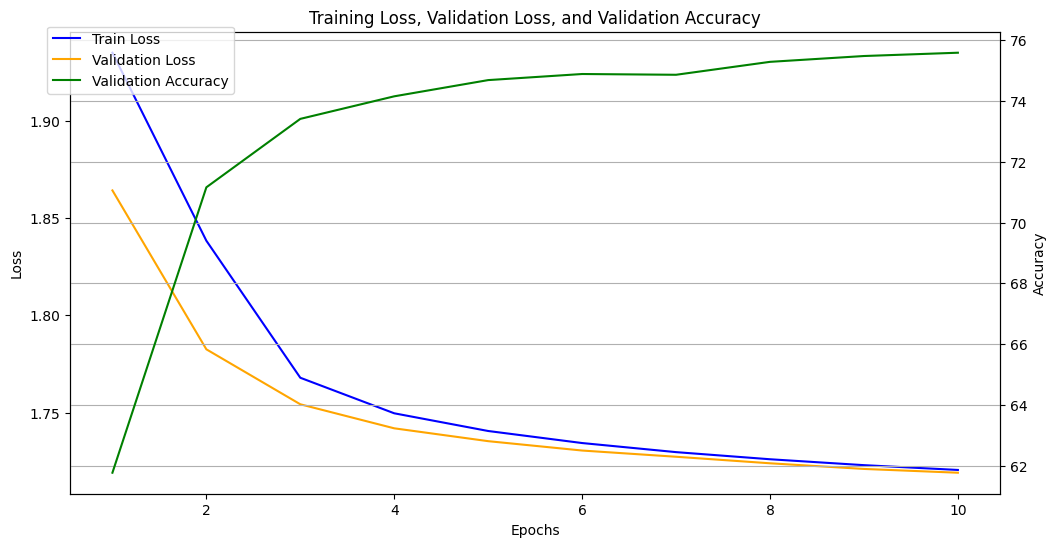

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# (1) Load the full Fashion MNIST dataset with torchvision.datasets
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
MNISTdataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)


# (2) Define batch size and instantiate the model
batch_size = 256
model = SoftmaxRegression(num_outputs=10, lr=0.1)

# (3) Instantiate the trainer with the full dataset (Trainer will handle splitting)
trainer = Trainer_cls(model=model, data=MNISTdataset, max_epochs=10, batch_size=batch_size, val_ratio=0.2, device='cpu')


# (4) Start training
trainer.fit()

# (5)plot the losses and accuracies
trainer.plot_losses()



# Multilayer Perceptrons for Classification 

###  Build 3-layer Multilayer Perceptrons (MLP) for classification on MNIST dataset

Completing the class `MLP` with torch. The architecture of the MLP to be built is 3-layer with ReLU as the activation function. And there is a dropout layer for after layer 1/layer 2's activation.

In [9]:
import torch.nn.functional as F

class MLP(nn.Module):
    """The softmax regression model."""
    def __init__(self, num_outputs,num_hiddens1,num_hiddens2,dropout_rate, lr):
        super(MLP, self).__init__()
        self.lr = lr
        # Flatten -> linear -> ReLU -> Dropout -> linear -> ReLU -> Dropout -> linear
        self.net = nn.Sequential(
            nn.Flatten(),  # Flatten the input tensor
            nn.Linear(28 * 28, num_hiddens1),  # First hidden layer
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_rate),  # Dropout after first hidden layer
            nn.Linear(num_hiddens1, num_hiddens2),  # Second hidden layer
            nn.ReLU(),  # ReLU activation
            nn.Dropout(dropout_rate),  # Dropout after second hidden layer
            nn.Linear(num_hiddens2, num_outputs)  # Output layer
        )

    # similar with  task 5
    def forward(self, X):
        logits = self.net(X)
        return logits

    # similar with  task 5
    def loss(self, Y_hat, Y, averaged=True):

        return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'sum')

    # similar with  task 5
    def optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

### Trainning the Model


Epoch [1/10]: Train Loss: 1.1546, Val Loss: 0.6420, Val Acc: 75.10%
Epoch [2/10]: Train Loss: 0.7288, Val Loss: 0.5492, Val Acc: 79.84%
Epoch [3/10]: Train Loss: 0.6425, Val Loss: 0.5001, Val Acc: 82.17%
Epoch [4/10]: Train Loss: 0.5940, Val Loss: 0.4552, Val Acc: 83.22%
Epoch [5/10]: Train Loss: 0.5601, Val Loss: 0.4361, Val Acc: 84.51%
Epoch [6/10]: Train Loss: 0.5414, Val Loss: 0.4259, Val Acc: 84.58%
Epoch [7/10]: Train Loss: 0.5210, Val Loss: 0.4222, Val Acc: 84.56%
Epoch [8/10]: Train Loss: 0.5079, Val Loss: 0.4089, Val Acc: 84.72%
Epoch [9/10]: Train Loss: 0.4978, Val Loss: 0.4021, Val Acc: 85.22%
Epoch [10/10]: Train Loss: 0.4826, Val Loss: 0.4049, Val Acc: 85.29%


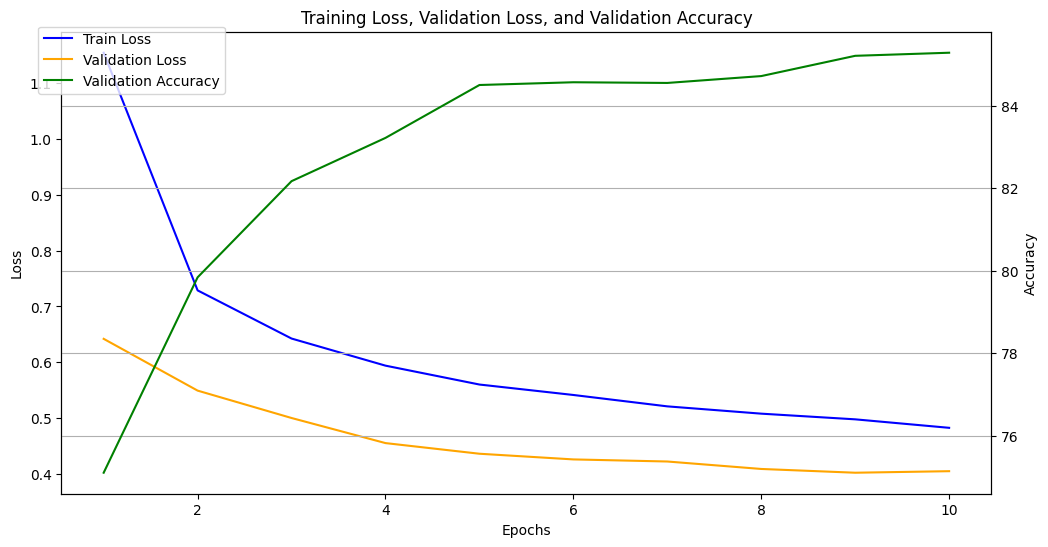

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Use the full Fashion MNIST dataset from Task 7
MNISTdataset = MNISTdataset

# (1) Define batch size and instantiate the MLP model with your selected hyperparameters.
batch_size = 256
num_outputs = 10  # Number of classes for Fashion MNIST
num_hiddens1 = 128  # Number of units in the first hidden layer
num_hiddens2 = 64   # Number of units in the second hidden layer
dropout_rate = 0.5  # Dropout rate
learning_rate = 0.1

model = MLP(num_outputs=num_outputs, num_hiddens1=num_hiddens1, num_hiddens2=num_hiddens2, dropout_rate=dropout_rate, lr=learning_rate)

# (2) Instantiate the trainer with the full dataset (Trainer will handle splitting)
trainer = Trainer_cls(model=model, data=MNISTdataset, max_epochs=10, batch_size=batch_size, val_ratio=0.2, device='cpu')

# (3) Start training
trainer.fit()


# (4)plot the losses and accuracies
# should have better performance than single-layer neural network classifier
trainer.plot_losses()

#  Convolutional Neural Networks

## Implement the 2-dimensional Convolutional Operator 

Here, we are going to implement the 2-dimensional convolutional operator with padding and stride from the scratch.


### Completing the following `corr2d` function as the 2-dimensional convolutional operator with padding and stride.

In [11]:
# X is the input image and K is the kernel for convolutional operator
def corr2d(X0, K, stride=1, padding=0):
    # (1) Add padding to the height and width of the image to get the X with padding, you can use torch.nn.functional.pad.
    if padding > 0:
        X = F.pad(X0, (padding, padding, padding, padding))  # Padding on all sides (left, right, top, bottom)
    else:
        X = X0

    # (2) Compute the height and width of Y after convolution given stride, padding size and kernel shape.
    h, w = K.shape
    Y_h = (X.shape[0] - h + 2 * padding) // stride + 1
    Y_w = (X.shape[1] - w + 2 * padding) // stride + 1

    Y = torch.zeros((Y_h, Y_w))

    # (3) compute the value for each pixel of Y
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            x_start = i * stride
            x_end = x_start + h
            y_start = j * stride
            y_end = y_start + w
            X_slice = X[x_start:min(x_end, X.shape[0]), y_start:min(y_end, X.shape[1])]

            if X_slice.shape != K.shape:
                pad_h = K.shape[0] - X_slice.shape[0]
                pad_w = K.shape[1] - X_slice.shape[1]
                X_slice = F.pad(X_slice, (0, pad_w, 0, pad_h))

            Y[i, j] = (X_slice * K).sum()

    return Y

Run the following code to check implementation of corr2d, the result should be:


tensor([[19., 25.],
        [37., 43.]])
tensor([[ 0.,  3.,  8.,  4.],
        [ 9., 19., 25., 10.],
        [21., 37., 43., 16.],
        [ 6.,  7.,  8.,  0.]])
tensor([[ 0.,  8.],
        [21., 43.]])
tensor([[0., 4.],
        [6., 0.]])
tensor([[0.]])

In [12]:
# Check your result here, help to adjust corr2d implementation
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
print(corr2d(X, K, stride=1, padding=0))
print(corr2d(X, K, stride=1, padding=1))
print(corr2d(X, K, stride=2, padding=1))
print(corr2d(X, K, stride=3, padding=1))
print(corr2d(X, K, stride=4, padding=1))

tensor([[19., 25.],
        [37., 43.]])
tensor([[ 0.,  3.,  8.,  4.,  0.,  0.],
        [ 9., 19., 25., 10.,  0.,  0.],
        [21., 37., 43., 16.,  0.,  0.],
        [ 6.,  7.,  8.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])
tensor([[ 0.,  8.,  0.],
        [21., 43.,  0.],
        [ 0.,  0.,  0.]])
tensor([[0., 4.],
        [6., 0.]])
tensor([[0., 0.],
        [0., 0.]])


## Learn the kernel 

The kernel `K` in `corr2d` is the above is the target to be learnt for Convolutional Neural Networks. We will show it in a simple example.

We first build a toy image with shape (8,6), where row 1-3, 6-8 are white and row 4-5 are black.

In [13]:
X = torch.ones((8, 6))
X[3:5,] = 0
X

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Then, we handcraft a kernel `K` as a horizontal edge detector. `corr2d(X, K)` gives the output as：

In [14]:
K = torch.tensor([[1.0], [-1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

If we transpose the image, `corr2d(X, K)` will output:

In [15]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

It indicates that kernel `K = torch.tensor([[1.0], [-1.0]])` can only detect horizontal edges not vertical ones.

Further, we can treat the `K` as an unknown kernel to learn. `K` is a kenerl in the convolution operation that leads to horizontal edge awareness.

Thus, to learn the unknown `K` given above `X` and `Y`, we can treat `K` as the weight of a single-layer neural network but in the manner of convolution operation to perform forward propagation.

### A simple Conv2D model
In the following, we build a simple Conv2D model class `Conv2D` without bias term for learning the horizontal edge detector kernel `K`.

In [16]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size,stride=1, padding=0):
        super().__init__()
        # (1) define the weight using nn.Parameter to parameterize K, define stride and padding.
        self.weight = nn.Parameter(torch.randn(kernel_size))  # Randomly initialize the kernel weights
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # (2) forward propagation of x with parameterized kernel self.weight in the manner of corr2d
        return corr2d(x, self.weight, stride=self.stride, padding=self.padding)

### Fitting the simple Conv2D model to find the horizontal edge detector kernel


In [17]:
# (1) Instantiate your model with your defined 'Conv2D'
conv2d = Conv2D(kernel_size=(2, 1), stride=1, padding=0)
lr = 1e-2  # Learning rate

# (2) Training
for i in range(100):
    # forward propagation
    Y_hat = conv2d(X)
    # squared loss computation
    l = ((Y_hat - Y) ** 2).mean()
    # clear gradient and back propagation to get the gradient
    conv2d.zero_grad()
    l.sum().backward()
    # update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad

    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 0.781
epoch 4, loss 0.734
epoch 6, loss 0.691
epoch 8, loss 0.653
epoch 10, loss 0.617
epoch 12, loss 0.585
epoch 14, loss 0.556
epoch 16, loss 0.530
epoch 18, loss 0.505
epoch 20, loss 0.483
epoch 22, loss 0.463
epoch 24, loss 0.444
epoch 26, loss 0.427
epoch 28, loss 0.411
epoch 30, loss 0.397
epoch 32, loss 0.383
epoch 34, loss 0.371
epoch 36, loss 0.360
epoch 38, loss 0.349
epoch 40, loss 0.339
epoch 42, loss 0.330
epoch 44, loss 0.322
epoch 46, loss 0.314
epoch 48, loss 0.306
epoch 50, loss 0.299
epoch 52, loss 0.293
epoch 54, loss 0.287
epoch 56, loss 0.281
epoch 58, loss 0.276
epoch 60, loss 0.270
epoch 62, loss 0.265
epoch 64, loss 0.261
epoch 66, loss 0.256
epoch 68, loss 0.252
epoch 70, loss 0.248
epoch 72, loss 0.244
epoch 74, loss 0.240
epoch 76, loss 0.237
epoch 78, loss 0.233
epoch 80, loss 0.230
epoch 82, loss 0.226
epoch 84, loss 0.223
epoch 86, loss 0.220
epoch 88, loss 0.217
epoch 90, loss 0.214
epoch 92, loss 0.212
epoch 94, loss 0.209
epoch 96, loss 0.

Check your result by running following cell. It should be very closed to `tensor([[ 1.0000],[-1.0000]])`.

In [18]:
conv2d.weight.data.reshape((2, 1))


tensor([[ 0.2006],
        [-0.1383]])

## Implement modern Convolutional Neural Networks ResNet18 for classification 

We will implement [ResNet18](https://arxiv.org/pdf/1512.03385) a Convolutional Neural Network with Residual blocks.

We will implement the 18-layer version of ResNet. The architecture of ResNet18 is in following tabel (Tabel 1 of [paper](https://arxiv.org/pdf/1512.03385)):

# ![title](img/3.png)

We can find that ResNet18 has 6 modules. The first module is made of a convolutional layer, a batch normal layer and a max pooling layer. The 4 middle residual modules have different channel number 64, 128, 256, 512. Each residual module is made of two residual blocks. A residual block looks like this:

# ![title](img/2.png)


The 1x1 conv (right one) only applies to the first residual block of the 2nd, 3rd and 4th middle residual modules. The other (2 residual blocks of 1st middle residual module, 2nd residual blocks of the other middle residual modules) residual blocks are the left one.

After the first module and 4 residual modules, the last module includes an average pooling layer and full connected linear layer for prediction.

###  Implement ResNet18

In following, you will need complete `Residual` class to define a general residual block to formulate each residual module. And complete 6 modules in `ResNet` class (mainly 1st and last module, the residual modules are based on your `Residual` class). After it, you need to complete the `optimizers` and `loss` in `ResNet18` class.


In [19]:
import torch
import torch.nn as nn

class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        #recommend LazyConv2d for easier implementation
        # the first convolutional layer has kernel_size 3, padding 1. If it is the first residual block of the 2nd, 3rd and 4th middle residual modules, the stride is 2 (1 otherwise).
        # You may set the stride=strides as the stride value for the first convolutional layer of the residual block may vary. We can adjust it by control stride in the ResNet class,
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        # the second convolutional layer has kernel_size 3, padding 1, stride 1.
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=1)

        if use_1x1conv:
            # 1x1 conv residual connection (kernel_size 1, stride is 2) for the first residual block of the 2nd, 3rd and 4th middle residual modules.
            # You may set the stride=strides
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            # identity residual connection for other cases
            self.conv3 = None

        # define 2 batch norm layers in the residual block using LazyBatchNorm2d
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        # conv1 -> BN1 -> ReLU -> conv -> BN2 -> Y
        Y = F.relu(self.bn1(self.conv1(x)))
        Y = self.bn2(self.conv2(Y))

        # Residual term
        if self.conv3:
            x = self.conv3(x)

        # Y + residual term
        # ReLU activation for the final output
        return F.relu(Y + x)

class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(ResNet, self).__init__()
        self.net = nn.Sequential()
        # complete self.net.add_module('b1',)
        # use nn.Sequential to construct the 1st('b1') module
        # conv (padding 3) -> BN -> ReLU -> Max Pooling (padding 1)
        # check the above tabel and paper for other hyperparameters
        self.net.add_module('b1', nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ))

        for i, (num_residuals, num_channels) in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(num_residuals, num_channels, first_block=(i==0)))

        # complete self.net.add_module('last',)
        # use nn.Sequential to construct the 'last' module
        # AdaptiveAvgPool2d (1,1) -> Flatten -> Linear (input dimension: 512, output dimension: num_classes)
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        ))

        self.net.apply(self.init_cnn)

    def block(self, num_residuals, num_channels, first_block=False):
        layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                layers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                layers.append(Residual(num_channels))
        return nn.Sequential(*layers)

    def init_cnn(self,module):
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        # forward propagation
        return self.net(x)

class ResNet18(ResNet):
    def __init__(self, num_classes=10,lr=0.1):
        super(ResNet18, self).__init__(((2, 64), (2, 128), (2, 256), (2, 512)), num_classes)
        self.lr=lr

    def optimizers(self):
        # define the SGD optimizers
        return torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, weight_decay=1e-4)

    def loss(self, Y_hat, Y, averaged=True):
        # define the cross_entropy loss for classification

        return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'sum')


Epoch [1/10]: Train Loss: 0.4270, Val Loss: 0.2725, Val Acc: 90.13%
Epoch [2/10]: Train Loss: 0.2352, Val Loss: 0.2294, Val Acc: 91.67%
Epoch [3/10]: Train Loss: 0.1878, Val Loss: 0.2462, Val Acc: 90.84%
Epoch [4/10]: Train Loss: 0.1471, Val Loss: 0.2321, Val Acc: 91.92%
Epoch [5/10]: Train Loss: 0.1185, Val Loss: 0.2254, Val Acc: 92.32%
Epoch [6/10]: Train Loss: 0.0916, Val Loss: 0.2329, Val Acc: 92.51%
Epoch [7/10]: Train Loss: 0.0687, Val Loss: 0.2398, Val Acc: 92.88%
Epoch [8/10]: Train Loss: 0.0567, Val Loss: 0.2413, Val Acc: 92.93%
Epoch [9/10]: Train Loss: 0.0432, Val Loss: 0.2743, Val Acc: 92.38%
Epoch [10/10]: Train Loss: 0.0368, Val Loss: 0.3035, Val Acc: 92.12%


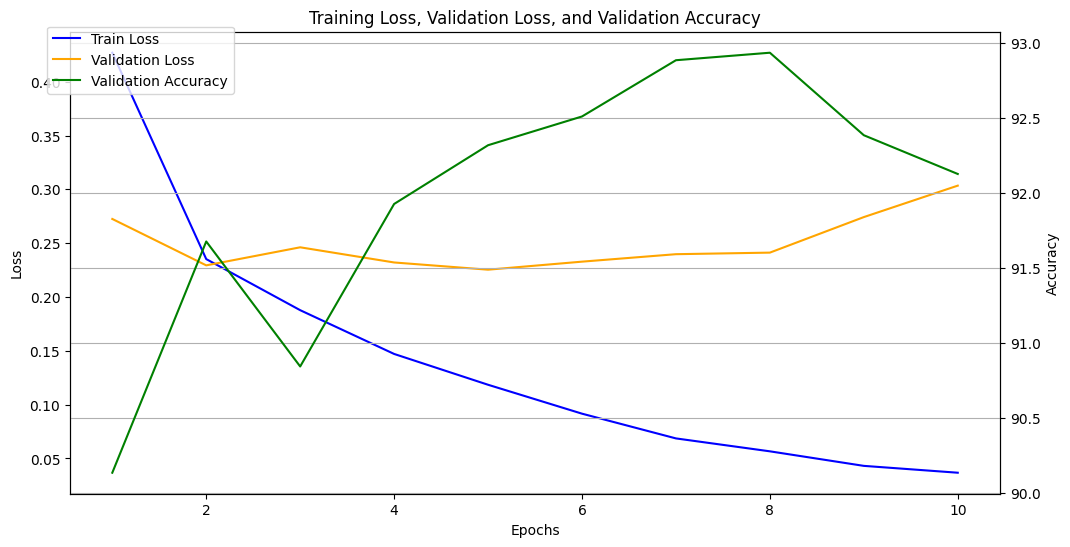

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# (1) add resize image to (96, 96) into the transform
# Load the full Fashion MNIST dataset with torchvision
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
MNISTdataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# (2) Define batch size and instantiate the ResNet18 model with lr=0.01
# set the model to GPU
batch_size = 256
model = ResNet18(lr=0.01).to('cuda')

# (3) Instantiate the trainer with the full dataset (Trainer will handle splitting)
# set device to cuda to have faster training
trainer = Trainer_cls(model=model, data=MNISTdataset, max_epochs=10, batch_size=batch_size, val_ratio=0.2, device='cuda')

# (4) Start training
trainer.fit()


# (5)plot the losses and accuracies
trainer.plot_losses()